# 9. 数值求解量子力学问题

在量子力学的体系中，其实只有很少的量子系统拥有严格的解析解。这些系统包括我们已经学习过的谐振子、方势井、氢原子等。这也是数值计算的方法如此重要的原因。

## 9.1 不含时薛定谔方程基础

我们首先快速回顾我们已经很熟悉的不含时的薛定谔方程。在分离变量之后，不含时的薛定谔方程可以写作：
$$
-\frac{\hbar^2}{2m}\nabla^2 \psi + V(\vec{r})\psi  = E \psi
$$


该方程的解，波函数$\psi(\vec{r})$是一种很特殊的物理量，以至于在经典理论中无法找到类比。而波函数最重要的物理意义在于，其模方$\psi^*(\vec{r})\psi(\vec{r})$ 代表了粒子在$\vec{r}$处出现的单位体积的概率。

尽管和之前学习到过的微分方程有很多类似的地方，薛定谔方程，或者量子力学系统最重要的不同点，也是最大的复杂性，在于能量（能量本征值）$E$未知！这也是能量有可能呈现分立的状态的原因。

考虑在一个一维的无限深方势井的势能下
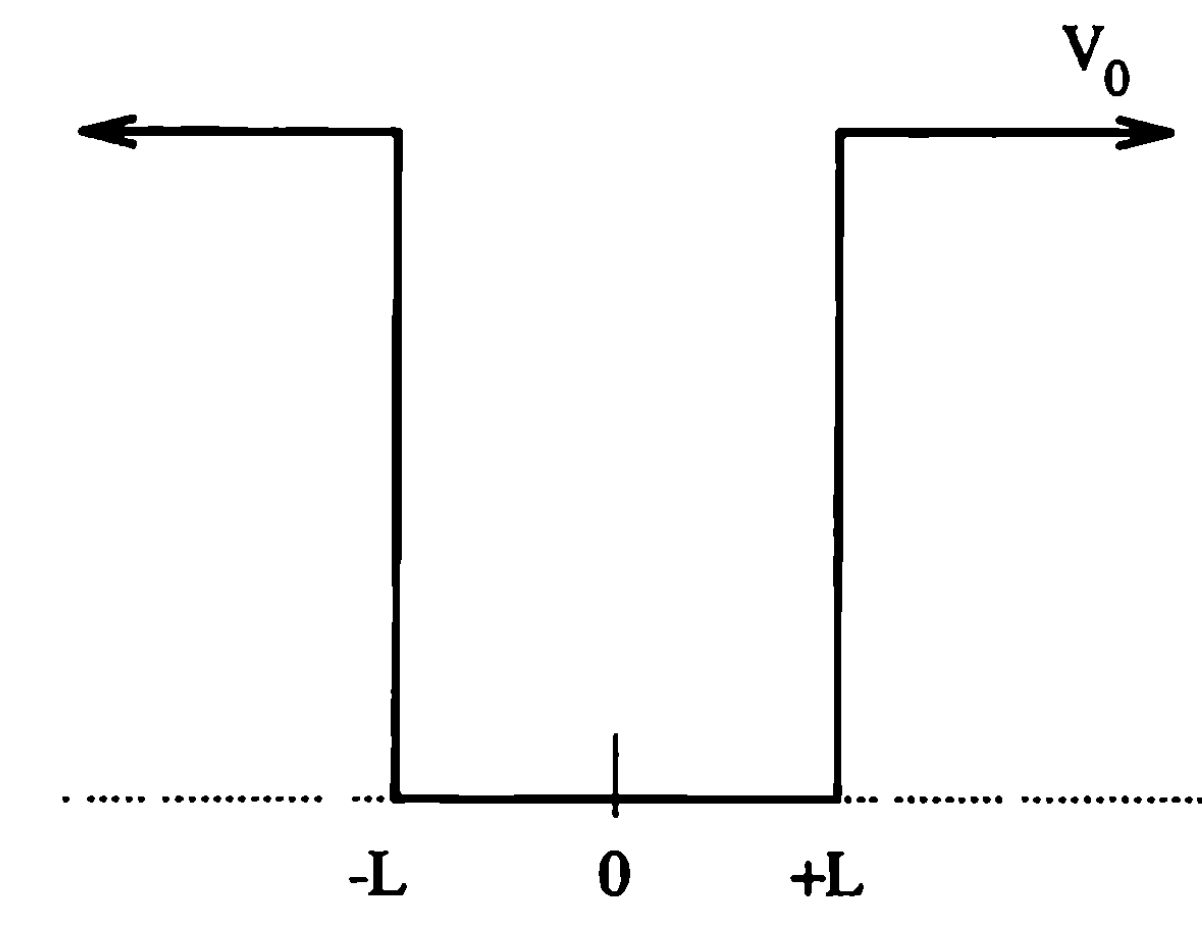

$\psi$理应满足边界条件$\psi_{\rm outside}=0$。这让我们可以建立这样的两组解：
$$
\begin{eqnarray}
\psi_+ = \frac{A}{2}[\exp(jk_+x) + \exp(-jk_+ x)] = A \cos(k_+ x) \\
\psi_- = \frac{A}{2}[\exp(jk_-x) - \exp(-jk_- x)] = A \sin(k_- x)
\end{eqnarray}
$$

其中
$$
k_+ = \frac{\pi}{2L}, \, \frac{3\pi}{2L}, \, \frac{5\pi}{2L}...
$$

$$
k_- = \frac{\pi}{L}, \, \frac{2\pi}{L}, \, \frac{3\pi}{L}...
$$

详细的内容见课堂板书，以后会在该笔记里补全！

### 9.1.1 Shooting 方法求解一维不含时薛定谔方程

下面，我们将针对这种在方势井中的粒子波函数，进行数值求解。

首先，让我们再次观察以为情况下不含时的薛定谔方程的形式，其实是一个二阶的常微分方程。我们理应可以使用我们在这学期刚开始学到过的欧拉方法，或者上节课学到过的Verlet方法，通过对方程积分，对其进行求解。


#### 根据对称性求解

而求解的前提，是知道$\psi(x)$以及$d\psi(x) / dx$在某个点上的初始值。而这个初始值，我们可以通过对称性得到。

我们刚才提到，对于势能项具有偶对称性的薛定谔方程，其解也具有一定的对称性。

那么，假如我们感兴趣的是具有偶对称性的解，那么该解一定满足$d\psi / dx = 0$，在$x=0$处。而因为薛定谔方程具有线性性，所以$\psi(x=0)$处的值，可以简单设置为1，之后可以再统一的做归一化处理。

对于具有奇对称性的解，其$\psi(x=0)=0$, 而$\psi'(x=0)$处的值也可以设置为1。

这样，我们成功的对具有不同对称性的解，设置了不同的初始条件。接下来我们可以使用之前提到过的对于二阶导数的离散化方法，把薛定谔方程改写成：
$$
\frac{\hbar^2}{2m} \frac{d^2 \psi}{ dx^2} \approx  - \frac{\hbar^2}{2m}\left[\frac{\psi_{n+1} + \psi_{n-1} - 2\psi_n}{(\Delta x)^2}\right] = (E - V_n) \psi_n
$$



接下来我们可以考虑使用我们在上一章刚学习过的Verlet方法，得到这样的递推关系式：
$$
\psi_{n+1} = 2 \psi_n - \psi_{n-1} - 2 (\Delta x)^2 (E-V_n) \psi_n.
$$
其中$V_n = V(n\Delta x)$，且$\hbar=m=1$（思考一下这样做时候，方程所涉及到的物理单位该如何计算？）。



对于$d\psi(x=0) / dx = 0$的解，有$\psi_0 = \psi_{-1}=1$。

而对于$d\psi(x=0) / dx = 1$的解，我们也可以类似的令$\psi_{-1} = - \Delta x$来作为我们递推时所使用的初值。

然而，跟之前我们求结果的二维抛射物体的问题有所不同，这种数值积分的策略，其结果在边界$\pm L$上并不能一定使得边界条件被满足。

比如，如果我们考虑无限深方势井，那么$\psi$需要在$\pm L$处为0，而这一条件对于不同的$E$来说并不会一定成立。事实上，解析的结果已经告诉我们对于哪些$E$，该边界条件会满足。

> 这个问题可以类比于这样一个经典物理问题：如何找到某个特定的初速度，让以不变的角度抛射的炮弹正好落在某处。

因此，类似的，我们也可以使用这样“射击（shooting）”的思路，不断调整能量$E$，直到满足需要的边界条件（打到靶上）。

而调整也需要一定的策略。例如，如果我们要寻找合适的基态能量$E_G$，当$E$不等于$E_G$的时候，波函数的表现入下图所示。

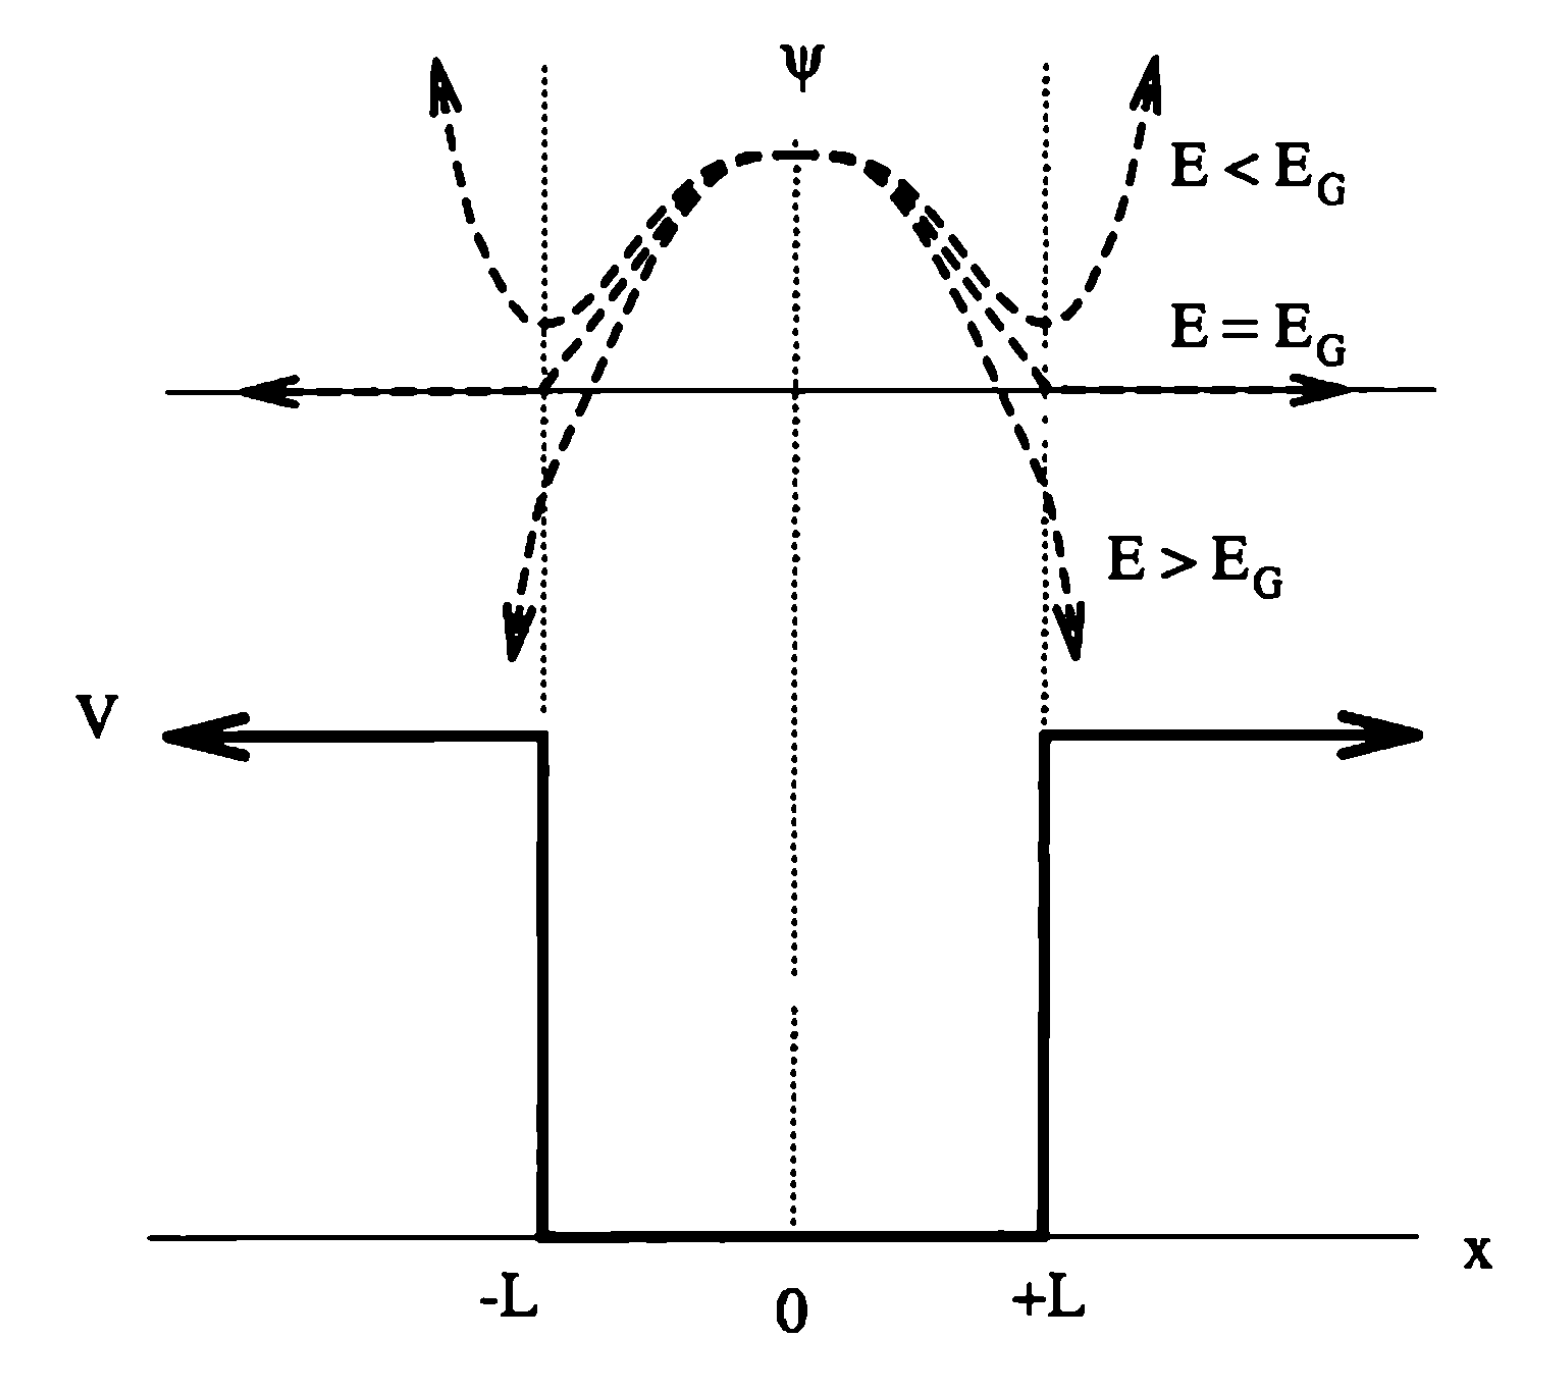

一旦我们知道了在$E<E_G$和$E>E_G$时波函数的形状，寻找合适的$E$的方法就一目了然了。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
def curve_plot(xs, ys, xlabel='x', ylabel='y', legends=None,
               xlim=None, ylim=None, scatter=False, title=None, figsize=(10,6), logx=False, logy=False):

    if isinstance(xs, np.ndarray):
        xs = [xs]
    if isinstance(ys, np.ndarray):
        ys = [ys]
    
    # 调整图片的大小
    plt.figure(figsize=figsize)
    
    # 画出轨迹
    for x, y in zip(xs, ys):
        if(scatter == False):
            plt.plot(x, y)
        else:
            plt.scatter(x,y)
    
    # 加入x轴标记
    plt.xlabel(xlabel, fontsize=24)
    # 加入y轴标记
    plt.ylabel(ylabel, fontsize=24)

    if(legends != None):
        plt.legend(legends, fontsize=24)
    if(xlim != None):
        plt.xlim(xlim)
    if(ylim != None):
        plt.ylim(ylim)
    if(title!= None):
        plt.title(title, fontsize=24)

    if(logx ==True):
        plt.xscale('log')
    if(logy ==True):
        plt.yscale('log')

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.show()

In [3]:
# 定义无限深方势井势能
def V(x, wall):
    if( x < wall and x > -wall):
        return 0
    else:
        # 如果x在势井外，返回一个较大的值
        return 1000

# 当能量本征值为E时，从做向右进行verlet积分
def integral(E, psi_0, psi_m1, L, wall, N):
    dx = L / N
    psi = np.zeros(N + 1)
    psi[0] = psi_0
    # psi[1]的值利用psi_m1和psi_0的值计算
    psi[1] = 2 * psi[0] - psi_m1 - 2 * (E - V(dx, wall)) * dx**2 * psi[0]

    # verlet方法递推
    for i in range(2, N + 1):
        psi[i] = 2 * psi[i-1] - psi[i-2] - 2 * (E - V(i*dx, wall)) * dx**2 * psi[i-1]
    return psi

# 用shooting法，计算满足边界条件的波函数
def calculate(L, wall, N, E_0, dE, tar_prec=1e-5, parity='even'):

    dx = L / N
    # 当宇称为偶时，令psi=1， psi'=0,即psi_m1=psi
    # psi_m1 为psi_0左边的项
    if(parity == 'even'):
        psi_0, psi_m1 = 1, 1
    else:
        print('宇称为odd的解尚未完成')

    # 上一次shooting的结果psi_old
    psi_old = integral(E_0, psi_0, psi_m1, L, wall, N)
    E = E_0
    psi_all = [psi_old] # 储存所有尝试过的psi

    
    while(np.abs(dE) > tar_prec):
        print('当前尝试的能量本征值为： ', E)
        # 改变能量的值
        E += dE
        # 数值积分
        psi = integral(E, psi_0, psi_m1, L, wall, N)

        # 如果本次shooting和上次shooting在势井最右边的结果不一致
        # 则让改变dE的符号，并令其/2
        if(psi[-1] * psi_old[-1] < 0):
            dE = -dE / 2
        # 储存所有尝试过的psi
        psi_all.append(psi.copy())
        # 将本次的结果存为上一次的结果，并继续迭代
        psi_old = psi.copy()
        
    return psi, psi_all

In [4]:
L = 1.3
N = 100
wall = 1
E_0 = 1
dE = 0.1
psi, psi_all = calculate(L,wall, N, E_0, dE)

当前尝试的能量本征值为：  1
当前尝试的能量本征值为：  1.1
当前尝试的能量本征值为：  1.2000000000000002
当前尝试的能量本征值为：  1.3000000000000003
当前尝试的能量本征值为：  1.2500000000000002
当前尝试的能量本征值为：  1.2000000000000002
当前尝试的能量本征值为：  1.225
当前尝试的能量本征值为：  1.2125000000000001
当前尝试的能量本征值为：  1.2000000000000002
当前尝试的能量本征值为：  1.2062500000000003
当前尝试的能量本征值为：  1.2125000000000004
当前尝试的能量本征值为：  1.2093750000000003
当前尝试的能量本征值为：  1.2062500000000003
当前尝试的能量本征值为：  1.2078125000000002
当前尝试的能量本征值为：  1.2070312500000002
当前尝试的能量本征值为：  1.2062500000000003
当前尝试的能量本征值为：  1.2066406250000004
当前尝试的能量本征值为：  1.2064453125000003
当前尝试的能量本征值为：  1.2062500000000003
当前尝试的能量本征值为：  1.2063476562500002
当前尝试的能量本征值为：  1.2062988281250002
当前尝试的能量本征值为：  1.2062500000000003
当前尝试的能量本征值为：  1.2062744140625004


按照我们所约定的$\hbar=m=1$，能量本征值$E=\hbar^2 k ^2 / 2m = k_G^2 / 2 = \pi^2 / (8 L^2)$。当$L=1$时，$E\approx1.2337$。

可以看到我们的结果非常接近于真实的能量本征值。其中，微小的差距主要是由于有限的分辨率、精度、和势能的大小并不是无穷所导致的。

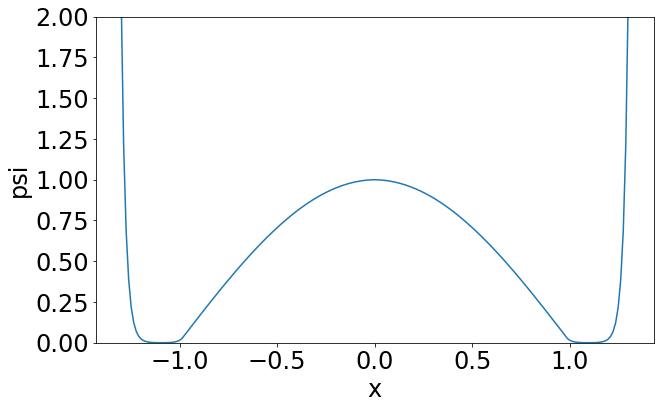

In [5]:
# 注意，我们仅仅针对一半的psi进行积分，画图时需要给出
# 另一个半的x坐标和psi的大小，这一点可以利用偶函数性质来做到
xs = np.concatenate([-np.flip(np.linspace(0, L, N + 1)), np.linspace(0, L, N + 1)])
ys = np.concatenate([np.flip(psi), psi])

curve_plot([ xs], [ys], xlabel='x', ylabel='psi', ylim=[0, 2])

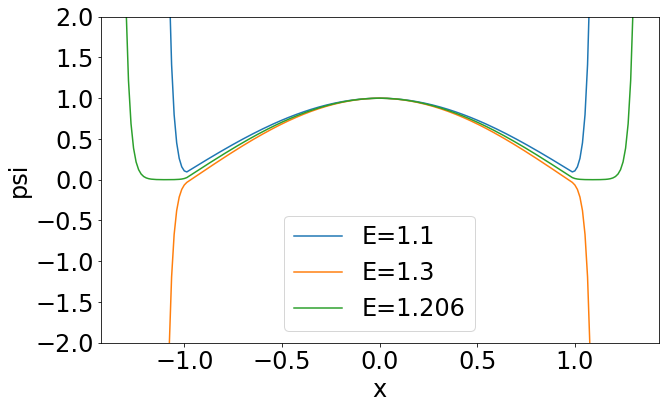

In [6]:
# 分别画出shooting过程中三个不同的E对应的psi
ys1 = np.concatenate([np.flip(psi_all[1]), psi_all[1]])

ys2 = np.concatenate([np.flip(psi_all[3]), psi_all[3]])

ys3 = np.concatenate([np.flip(psi_all[-1]), psi_all[-1]])


curve_plot([ xs]*3, [ys1, ys2, ys3], xlabel='x', ylabel='psi', ylim=[-2, 2], 
           legends=['E=1.1', 'E=1.3', 'E=1.206'])

至于具有odd parity的基态解的寻找，请大家在作业中解决。

#### 不具有对称性的势能函数求解（二重shooting法）

有些时候，势能函数并不具有偶宇称的特性，这时对应的波函数解往往也不具有对称性。那么，此时该如何设定初值从而求解呢？

我们以上一章使用过的Lenard-Jones势为例。
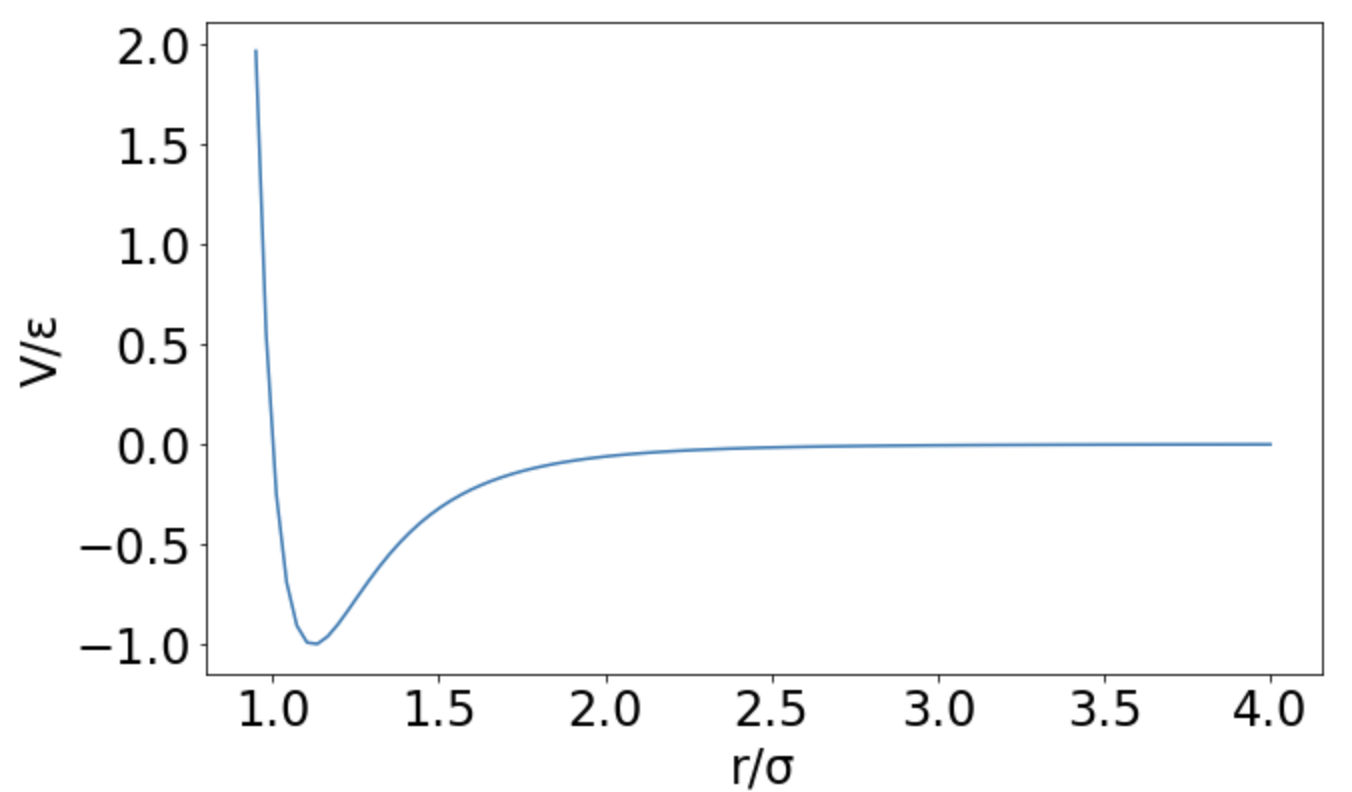


如何寻找Lenard-Jones势所对应的基态解？

尽管我们不知道解的具体形状，但有一点我们可以确认，那就是解一定会在$r/\sigma=0$和$r/\sigma=+\infty$处为0。

随后，我们可以自然的推断，在$0$到$+\infty$之间，一定至少有一个极点。

因此，如果我们可以知道这个极点的准确位置，只要从该位置出发，向左右分别shooting，自然就可以得到能量本征值和对应的波函数了。

**然而，怎样才能准确的找到极点的位置呢？**

我们先思考，如果极点位置距离准确的位置有偏差会怎样？

如果极点位置不准确，我们首先向右shooting，理论上可以扔然可以确定一个能量本征值$E_R$。
而如果将这个$E_R$用来向左边积分，由于极点位置并不准确，我们大概率会在左半边得到一个并不能收敛到0的解。

而极点位置的偏左或者偏右，很大可能决定了左边这个解是上翘还是下压。

**因此，我们也可以类似的，对极点位置也采用shooting策略。**

In [713]:
def V(x, eps):
    
    return 4 * eps * (x**-12 - x**-6)

# 在能量本征值为E的时候，完成一次向左或者向右的数值积分
def integral(E, L, N, psi_0, psi_m1, eps, dx):
    
    psi = np.zeros(N + 1)
    psi[0] = psi_0
    psi[1] = 2 * psi[0] - psi_m1 - 2 * (E - V(L + dx, eps)) * dx**2 * psi[0] 
    for i in range(2, N + 1):
        psi[i] = 2 * psi[i-1] - psi[i-2] - 2 * (E - V(L + i*dx, eps)) * dx**2 * psi[i-1]
        if(np.abs(psi[i]) > 1e3):
            psi[i] = 1e6 * np.sign(psi[i])
    return psi

# 使用shooting方法，找到满足右边psi的能量本征值
# 起点的x坐标为peak0
def update(L, R, peak0, eps, N, E_0, dE, tar_prec=1e-5):
    
    psiR_0 = 1
    psiR_m1 = 1
    
    
    psiR_old = integral(E_0, peak0, N, psiR_0, psiR_m1, eps, (R - peak0) / N)

    #设置迭代次数的上限
    cnt = 0
    E = E_0
    
    while(np.abs(dE) > tar_prec and cnt < 50):
        cnt += 1

        E += dE 
        psiR = integral(E, peak0, N, psiR_0, psiR_m1, eps, (R - peak0) / N)
        if(psiR_old[-1] * psiR[-1] < 0):
            dE = -dE / 2
        psiR_old = psiR.copy()

    # 返回E和psi_R
    return E, psiR

def calculate(L, R, peak0, eps, N, E_0, dE, dp, tar_prec=1e-5):

    # 返回初始时右边psi的能量本征值
    E, psiR_old = update(L, R, peak0, eps, N, E_0, dE, tar_prec)

    psiL_0 = 1
    psiL_m1 = 1

    # 在初始的能量本征值的基础上，对左半边的psi数值积分
    psiL_old = integral(E, peak0, N, psiL_0, psiL_m1, eps, -(peak0 - L) / N)

    peak = peak0

    cnt = 0

    # 针对极点位置peak进行shooting
    while(np.abs(dp) > tar_prec and cnt < 50):
        peak += dp

        E, psiR = update(L, R, peak, eps, N, E_0, dE, tar_prec)
        
        psiL = integral(E, peak, N, psiL_0, psiL_m1, eps, -(peak0 - L) / N)

        # 改变迭代方向的条件：左半边psi在边界上的符号改变
        if(psiL[-1] * psiL_old[-1] < 0):
            dp = - dp / 2

        psiL_old = psiL.copy()
        cnt+= 1
        
    return psiL, psiR, peak, E

In [714]:
L = 0.5
R = 5
N = 500
E_0 = -2.2
dE = 0.1
peak0 = 1.2
psiL, psiR, peak, E = calculate(L, R, peak0, 10, N, E_0, dE, 0.1,  tar_prec=1e-8)

In [715]:
peak, E

(1.3225800633430482, -1.8627166867256164)

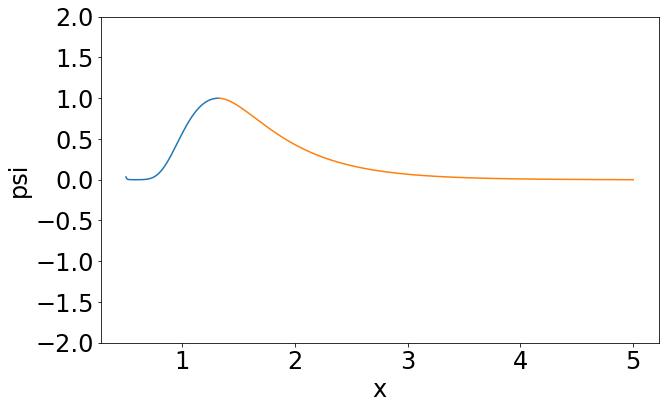

In [716]:
xL = np.flip(np.linspace(L, peak, N+1))
xR = np.linspace(peak, R, N+1)

curve_plot([ xL, xR], [psiL, psiR], xlabel='x', ylabel='psi', ylim=[-2,2])


### 变分法求解薛定谔方程

使用二重shooting的方法，虽然有效，但稍微比较复杂，也很难扩展到二维或者更高维度的情况。

基于之前学习过的蒙特卡罗的思想，我们可以使用基于蒙特卡罗算法的“变分法”，来求解薛定谔方程。

回想我们在理论力学中学习到的最小作用量原理：物体的轨迹对应了作用量的极小值。

而我们在量子力学中的“轨迹”即为波函数，而不含时薛定谔方程中的作用量，就等价于系统能量。

而我们能够计算能量的前提是找到哈密顿算符的本征函数与本征值，因此，在找到能量之前，
我们可以定义一个“伪”能量$E^*$：


$$
E^* \equiv \frac{\int \psi^* \mathcal{H} \psi dx}{\int \psi^* \psi dx}.
$$

可以证明，如果$\psi$等于真正的基态波函数$\psi$，$E^*$会取得最小值（同时也是极小值）。而如果$\psi$距离真正的基态波函数有偏离，那么$E^*$理论上会取得更大的值。

基于此，我们可以设计一套基于蒙特卡罗的算法--在当前的$\psi$的值的基础上，随机的使其改变，如果这个改变能够让$E^*$变小，那么就保留这个改变。按照这种方式，以期待取得更好的$\psi$。

In [718]:
# 定义势能函数
def V(x):
    return 4 * 10 * (x**-12 - x**-6)
# 对波函数进行归一化
def norm(psi, dr):
    # 用求和近似积分
    return psi / np.sqrt((psi ** 2).sum() * dr)
# 计算E*
def E_star(psi, L, N, dr):
    sum = 0
    # 用求和近似积分
    for i in range(1, N - 1):
        # 将哈密顿算符H作用在psi上，得到Hpsi
        H_psi = - (psi[i+1] - 2 * psi[i] + psi[i-1] ) / (dr**2) / 2 + V(L + dr * i) * psi[i]
        sum += H_psi * psi[i]
    return sum * dr

def variation(psi0, L, R, N, n_iter, d_psi):
    dr = (R - L) / N
    psi = norm(psi0, dr)
    E_s_old = E_star(psi, L, N, dr)
    print('初始的E* 是', E_s_old)

    # 将当前尝试的psi备份
    psi_old = psi.copy()

    iter_cnt = 0
    while(iter_cnt < n_iter):
        # 随机选择1--N-1中的某一个位置
        rand_n = int(np.random.rand() * (N-2) ) + 1

        # 将该位置的psi改变+-d_psi * (-1, 1)之间的随机数
        psi[rand_n] += 2 * (np.random.rand() - 0.5) * d_psi

        # 将新的psi归一化
        psi = norm(psi, dr)
        # 计算新的psi对应的E*
        E_s = E_star(psi, L, N, dr)

        # 如果新的E_s小于之前的E_s_old
        if(E_s < E_s_old):
            # 接受这个psi作为当前的波函数psi，并备份其值
            psi_old = psi.copy()
            E_s_old = E_s
        else:# 否则，将psi还原
            psi = psi_old.copy()
        # 每进行5000次迭代输出当前的E*
        if(iter_cnt % 5000 == 0):
            print("迭代",iter_cnt, "次后的E*=", E_s_old)
        iter_cnt += 1
    print('最后的E* 是', E_s_old)
    return psi_old

In [723]:
N = 50
L = 0.7
R = 5
xs = np.linspace(L, R, N)
psi0 = np.zeros(N)
psi0[6:43] = 1

psi = variation(psi0, L, R, N, 100000, 0.02)

初始的E* 是 2.723158371654457
迭代 0 次后的E*= 2.723158371654457
迭代 5000 次后的E*= -0.8667196240012655
迭代 10000 次后的E*= -1.4957801717200703
迭代 15000 次后的E*= -1.7716207475727235
迭代 20000 次后的E*= -1.8510016614657614
迭代 25000 次后的E*= -1.8851031720461235
迭代 30000 次后的E*= -1.9046481745926684
迭代 35000 次后的E*= -1.9137136435177156
迭代 40000 次后的E*= -1.9193485870717355
迭代 45000 次后的E*= -1.9223562827476728
迭代 50000 次后的E*= -1.924394854496179
迭代 55000 次后的E*= -1.9261196991446374
迭代 60000 次后的E*= -1.9270356376699538
迭代 65000 次后的E*= -1.9278922681277249
迭代 70000 次后的E*= -1.9286834532530601
迭代 75000 次后的E*= -1.9292001222036732
迭代 80000 次后的E*= -1.9296496281012328
迭代 85000 次后的E*= -1.9298739883084484
迭代 90000 次后的E*= -1.9301116181588525
迭代 95000 次后的E*= -1.93035213144188
最后的E* 是 -1.9304693895738203


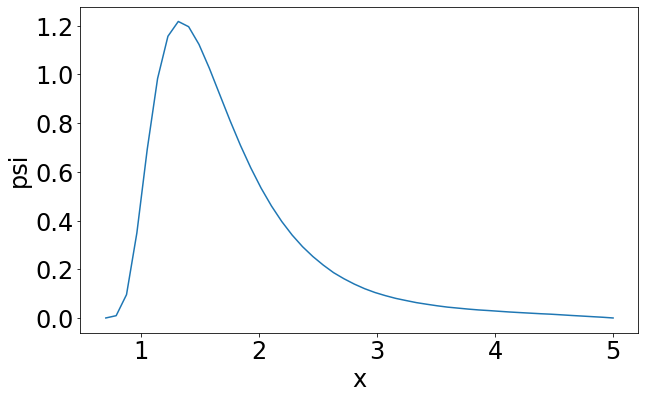

In [724]:
curve_plot(xs, psi, xlabel='x', ylabel='psi')

### 薛定谔方程的矩阵理解

见板书

In [725]:
# 定义势能函数
def V(x):
    return 4 * 10 * (x**-12 - x**-6)

In [726]:
N = 100
L = 0.5
R = 5
xs = np.linspace(L, R, N)
# 创建 N x N的矩阵
mat = np.zeros((N, N))

dx = (R - L) / N
# 通过循环创建矩阵
for i in range(N):
    mat[i, i] = 1 / dx**2 + V(L + i * dx) 
    if(i> 0 ):
        mat[i, i-1] = - 1/2 / dx**2
    if(i < N - 1):
        mat[i, i +1] = - 1/2 / dx**2


In [729]:
# 计算矩阵的特征值和特征函数
vals, vecs = np.linalg.eig(mat)

# 寻找本征值最小的位置对应的数组下标
min_idx = vals.argmin()


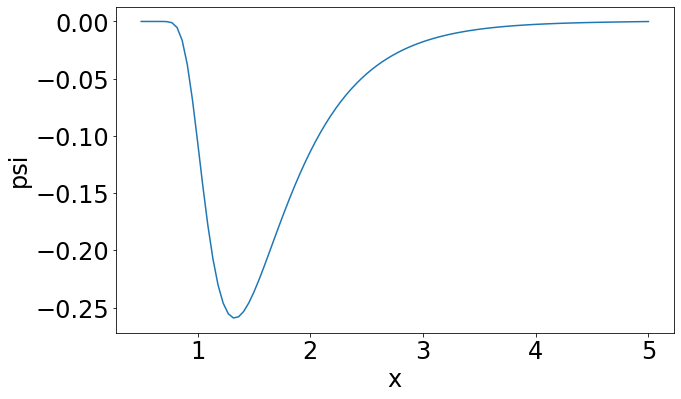

In [730]:
curve_plot(xs, vecs[:,min_idx], xlabel='x', ylabel='psi')